<h1 style="text-align: center; font-family: Verdana; font-size: 40px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; font-variant: small-caps; letter-spacing: 3px; color: #42288a; background-color: #ffffff;">DBSCAN + EfficientNet baseline</h1>

<h1 style="text-align: left; font-family: roboto; font-size: 20px; font-style: normal; font-weight: none; text-decoration: none; text-transform: none; font-variant: none;  color: #429ef5; background-color: #ffffff;">
    Density-Based Spacial Clustering of Applications with noise. It is an efficient clustering algoritm designed to be fast and effective. It is better than Kmeans clustering as it does not require us to select the number of clusters. <br>     <br>
    The Best case run time complexity of DBScan is <i> O(nlogn) </i> whereas for Kmeans, its <i> O(n<sup>2</sup>) </i> . It can even find arbitrary shaped clusters, for example a cluster that is surrounded by another cluster, but not connected to it. KMeans cannot do the same. <br>
    <br>
    In this notebook, we extract ImageNet EfficientNet embeddings and cluster them using <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html"> DBSCAN </a>.
    
</h1>


<br>
<h1 style="text-align: left; font-family: roboto; font-size: 25px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; color: #c75d16; background-color: #ffffff;">
ACKNOWLEDGMENTS
</h1>

<h1 style="text-align: left; font-family: roboto; font-size: 20px; font-style: normal; font-weight: none; text-decoration: none; text-transform: none; font-variant: none;  color: #eb8f52; background-color: #ffffff;">
    Making this wouldn't have been possible without the help of following notebooks, do check them out!

</h1>

<ul>
    <li> <a href="https://www.kaggle.com/jollibobert/efficientnet-dbscan-baseline-cv-0-658"> https://www.kaggle.com/jollibobert/efficientnet-dbscan-baseline-cv-0-658 </a> </li>
    <li> <a href="https://www.kaggle.com/ammarnassanalhajali/cnn-with-keras-stater"> https://www.kaggle.com/ammarnassanalhajali/cnn-with-keras-stater </a> </li>
    <li> <a href="https://www.kaggle.com/debarshichanda/pytorch-arcface-gem-pooling-starter"> https://www.kaggle.com/debarshichanda/pytorch-arcface-gem-pooling-starter </a> </li>
</ul>
 


### LOADING LIBRARIES AND DATA

In [1]:
import sys
sys.path.append("../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master")

# utils
import numpy as np 
import pandas as pd 
import math
import random 
import gc
import os 
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


# image utils
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

# DBSCAN and sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from cuml.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn import metrics
from cuml.metrics.pairwise_distances import pairwise_distances
import cupy

from sklearn.model_selection import StratifiedKFold

# deep learning & models
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

In [2]:
train = pd.read_csv("../input/happy-whale-and-dolphin/train.csv")
test = pd.read_csv("../input/happy-whale-and-dolphin/sample_submission.csv")

train.head()

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392


In [3]:
train.shape

(51033, 3)

### SET CONFIG

In [4]:
class Config:
    
    # models
    efficientnet_name = 'efficientnet-b2'  # 0 for b0, 1 for b1, etc
    
    # image size
    image_size = 256
    
    seed = 2022
    batch_size = 16
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    # dbscan metric - cosine/euclidean
    dbscan_metric = 'euclidean'
    

### DEFINING DATASET AND DATALOADER

<!-- <h1 style="text-align: left; font-family: arial; font-size: 15px; color: #91450a; background-color: #ffffff;">
    We will use a simple stratified train test split to tune the parameters of DBSCAN.
    
</h1> -->

In [5]:
# transform for pytorch
transforms = A.Compose([
        A.Resize(Config.image_size, Config.image_size),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)


# Dataset class
class HappyWhaleDataset(Dataset):
    def __init__(self, df, transforms, test=False):
        self.df = df
        self.transforms = transforms
        self.test = test
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        if self.test:            
            impath = f"../input/happy-whale-and-dolphin/test_images/{self.df.loc[idx, 'image']}"
        else:
            impath = f"../input/happy-whale-and-dolphin/train_images/{self.df.loc[idx, 'image']}"
            
        img = cv2.imread(impath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        img = self.transforms(image=img)["image"]
        
        return img


# map@5
# from - https://www.kaggle.com/pestipeti/explanation-of-map5-scoring-metric
def map_per_image(label, predictions): 
    try:
        return 1 / (predictions[:5].index(label) + 1)
    except ValueError:
        return 0.0

def map_per_set(labels, predictions):
    return np.mean([map_per_image(l, p) for l,p in zip(labels, predictions)])


In [6]:
whale_dt = HappyWhaleDataset(train, transforms)
whale_dataloader = torch.utils.data.DataLoader(whale_dt, batch_size = Config.batch_size,
                                              num_workers = 2, pin_memory=True, shuffle=False)

whale_test_dt = HappyWhaleDataset(test, transforms, "test")
whale_test_dataloader = torch.utils.data.DataLoader(whale_test_dt, batch_size = Config.batch_size,
                                              num_workers = 2, pin_memory=True, shuffle=False)


len(whale_dataloader)

3190

### DEFINING THE EFFICIENTNET

In [7]:
class WhaleModel(nn.Module):
    def __init__(self):
        super(WhaleModel, self).__init__()
        
        self.model = EfficientNet.from_name(Config.efficientnet_name, include_top=False)
        self.model.load_state_dict(torch.load(glob(f"../input/efficientnet-pytorch/{Config.efficientnet_name}*")[0]), 
                                  strict=False)
        print(f"{Config.efficientnet_name} weights loaded")
                
    def forward(self, img):
        
        return self.model.forward(img)
        
model = WhaleModel()
model = model.to(Config.device)

efficientnet-b2 weights loaded


### EXTRACT EMBEDDINGS

In [8]:
# The embedding generation takes around 50 mins, I have generate the embeddings beforehand and uploaded it in a Dataset.
# You can uncomment the below code to generate embeddings for some other efficientnet.

# image_embs = np.load("../input/happywhaleeffnetembs/effb0-train.npy")

# Uncomment to generate embeddings
model.eval()

embeddings = []

for bind, img in enumerate(tqdm(whale_dataloader)):
    img = img.to(Config.device)
    embs = model(img)
    
    embeddings.append(embs.cpu().detach().numpy())    
    
    del img, embs
    gc.collect()

image_embs = np.concatenate(embeddings).squeeze()

del embeddings
gc.collect()

image_embs.shape

  0%|          | 0/3190 [00:00<?, ?it/s]

(51033, 1408)

In [9]:
# TEST IMAGES EMBEDDINGS

# test_image_embs = np.load("../input/happywhaleeffnetembs/effb0-test.npy")

# uncomment to generate embeddings manually
embeddings = []

for bind, img in enumerate(tqdm(whale_test_dataloader)):
    img = img.to(Config.device)
    embs = model(img)
    
    embeddings.append(embs.cpu().detach().numpy())    
    
    del img, embs
    gc.collect()

test_image_embs = np.concatenate(embeddings).squeeze()

del model, embeddings
gc.collect()

test_image_embs.shape

  0%|          | 0/1748 [00:00<?, ?it/s]

(27956, 1408)

### FIT DBSCAN 

In [10]:
def train_dbscan(eps, min_samples, image_embs, verbose=True, metric = Config.dbscan_metric):
    
    db = DBSCAN(eps = eps, 
                min_samples = min_samples, 
                metric = 'euclidean', 
                calc_core_sample_indices = True,
                verbose = 0)

    # trick to use cosine by normalizing euclidean
    # https://medium.com/ai-for-real/relationship-between-cosine-similarity-and-euclidean-distance-7e283a277dff
    if metric == 'cosine':
        norms = cupy.linalg.norm(cupy.array(image_embs), ord=2, axis=1)
        image_embs = image_embs/norms.get().reshape(-1, 1)
    
    db.fit(image_embs)
        
    if verbose:
        print(f"Generated {len(db.core_sample_indices_)} clusters from {image_embs.shape[0]} data points")
    
    return db, len(db.core_sample_indices_)

### CALCULATE TRAIN CV SCORE

<h1 style="text-align: left; font-family: arial; font-size: 15px; color: #91450a; background-color: #ffffff;">
    eps 
   
    It is the most important parameter in DBSCAN. It is the maximum distance between two samples for one to be considered as in the neighborhood of the other.
    
    We will tune this parameter, by maximizing validation mAP score. The total number of individual ids in train set must be the number of clusters in the train set. Let us sweep different values of eps to select the best one.
    
</h1>

  0%|          | 0/60 [00:00<?, ?it/s]

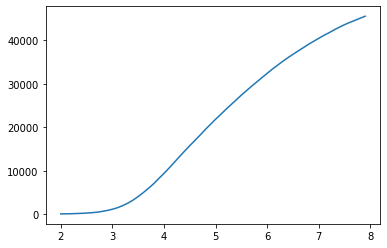

In [11]:
# trying out all values from 2 to 8 with steps of 0.1

numclus = []
for eps in tqdm(np.arange(2, 8, 0.1)):    
    numclus.append(train_dbscan(eps, 2, image_embs, verbose=False)[1])
    
    
plt.plot(np.arange(2, 8, 0.1), numclus)
plt.show()

In [12]:
print(f"Train set has {len(train.individual_id.value_counts())} different ids")

Train set has 15587 different ids


<h1 style="text-align: left; font-family: arial; font-size: 17px; color: #000000; background-color: #ffffff;">
    
    From the graph we can see that the best eps should be 5.5 (approx)  , Let us train with this eps and check validation score
    
</h1>

In [13]:
def dbscan_predict(db, train_embs, test_embs, metric = Config.dbscan_metric):
    
    core_samples_embs = train_embs[db.core_sample_indices_, :]
    print("Core image embeddings shape ", core_samples_embs.shape)
    
    predictions = []
    
    print(f"Predicting on {test_embs.shape[0]} test embeddings")
    for i in tqdm(range(test_embs.shape[0])):
        pred = []
        
        dists = pairwise_distances(core_samples_embs, test_embs[[i,], :], metric = metric)
        top5 = sorted(list(zip(dists, db.core_sample_indices_)))[:5]
        
        vals = [x[0] for x in top5]
        inds = [x[1] for x in top5]
        indids = [train.loc[x, 'individual_id'] for x in inds]
        
        if vals[0] > db.eps:
            pred.append(-1)
            pred.extend(indids[:4])
        else:
            pred.extend(indids)
            
        predictions.append(pred)
        
    print(f"Generated {len(predictions)} predictions for the test set")
    
    return predictions

In [14]:
dbscan_model, _ = train_dbscan(eps = 5.5,
                            min_samples = 2,
                            image_embs = image_embs)
  

# takes too much time to check complete train set - increase this if you want to check for more
CHECK_SIZE = 2500

predictions = dbscan_predict(dbscan_model, image_embs, image_embs[:CHECK_SIZE])
score = map_per_set(train.individual_id.tolist()[:CHECK_SIZE], predictions)

print(f"CV score - ", score)

Generated 27386 clusters from 51033 data points
Core image embeddings shape  (27386, 1408)
Predicting on 2500 test embeddings


  0%|          | 0/2500 [00:00<?, ?it/s]

Generated 2500 predictions for the test set
CV score -  0.5493


### TEST PREDICTION

In [15]:
test

,image,predictions
0,000110707af0ba.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
1,0006287ec424cb.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
2,000809ecb2ccad.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
3,00098d1376dab2.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
4,000b8d89c738bd.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
...,...,...
27951,fff6ff1989b5cd.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
27952,fff8fd932b42cb.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
27953,fff96371332c16.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...
27954,fffc1c4d3eabc7.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...


In [16]:
predictions = dbscan_predict(dbscan_model, image_embs, test_image_embs)


def process_preds(pred):
    s = " "
    if pred[0] == -1:
        s += "new_individual "
    else:
        s += str(pred[0]) + " "

    s += " ".join([str(x) for x in pred[1:]])

    s.strip()

    return s

test.loc[:, 'predlist'] = predictions
test.loc[:, 'predictions'] = test['predlist'].apply(process_preds)

test[['image', 'predictions']].to_csv("submission.csv", index=False)
pd.read_csv("submission.csv").head()

Core image embeddings shape  (27386, 1408)
Predicting on 27956 test embeddings


  0%|          | 0/27956 [00:00<?, ?it/s]

Generated 27956 predictions for the test set


,image,predictions
0,000110707af0ba.jpg,new_individual 398bc836ee35 fbe2b15b5481 a68e...
1,0006287ec424cb.jpg,new_individual 64cbd1f56354 f1dbe8514b17 69c5...
2,000809ecb2ccad.jpg,1ce3ba6a3c29 5a698db177c5 afbfd0d6b694 f46973...
3,00098d1376dab2.jpg,new_individual 8beb43dfa67e 938b7e931166 ad96...
4,000b8d89c738bd.jpg,da9cc7804e3a b29b59f352f5 e133efaea0f4 9a1324...


<br>
<h1 style="text-align: left; font-family: roboto; font-size: 25px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; color: #c75d16; background-color: #ffffff;">
POSSIBLE IMPROVEMENTS
</h1>

<ul>
    <li> We can use larger efficientnets to extract embeddings. </li>
    <li> We can train all the folds with DBSCAN and then combine the predictions  </li>
    <li> We can also train the efficients with ArcFace loss and then perform DBSCAN for better clusters </li>
</ul>

<h1 style="text-align: left; font-family: roboto; font-size: 20px; font-style: normal; font-weight: none; text-decoration: none; text-transform: none; font-variant: none;  color: #eb8f52; background-color: #ffffff;">
    Show your appreciation by a simple upvote! 😊

</h1>